In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [20]:
# 只读取抖音处理后数据
df = pd.read_csv("../processed_data/processed_psi_douyin.csv")
print(f"使用抖音数据: {len(df)} 行")

使用抖音数据: 10826 行


In [21]:
# 查看各 source_file 的行数和顺序
file_counts = df.groupby('source_file', sort=False).size()
for f, n in file_counts.items():
    print(f"  {f}: {n} 行")

  psi_douyin_20260228_211328.csv: 997 行
  psi_douyin_20260228_213146.csv: 1241 行
  psi_douyin_20260228_215103.csv: 1220 行
  psi_douyin_20260228_221442.csv: 1225 行
  psi_douyin_20260301_203427.csv: 1256 行
  psi_douyin_20260301_205453.csv: 1208 行
  psi_douyin_20260301_211527.csv: 1220 行
  psi_douyin_20260301_213426.csv: 1216 行
  psi_douyin_20260301_220936.csv: 1243 行


In [22]:
# 特征工程已统一放在 data_process 中，这里仅保留目标裁剪
upper = df["future_1s_some"].quantile(0.99)
print(f"future_1s_some 99th percentile: {upper:.0f}")
df["future_1s_some"] = df["future_1s_some"].clip(upper=upper)

print(f"使用已处理特征列数: {len(df.columns)}")

future_1s_some 99th percentile: 328424
使用已处理特征列数: 66


In [23]:
# 按文件级别切分：前 n-2 个文件训练，倒数第 2 个验证（早停），最后 1 个测试
all_files = list(df.groupby('source_file', sort=False).groups.keys())
print(f"共 {len(all_files)} 个文件")

train_files = all_files[:-2]
valid_files = [all_files[-2]]
test_files  = [all_files[-1]]

print(f"训练文件 ({len(train_files)}): {train_files}")
print(f"验证文件 ({len(valid_files)}): {valid_files}")
print(f"测试文件 ({len(test_files)}):  {test_files}")

train = df[df['source_file'].isin(train_files)].reset_index(drop=True)
valid = df[df['source_file'].isin(valid_files)].reset_index(drop=True)
test  = df[df['source_file'].isin(test_files)].reset_index(drop=True)

print(f"\nTrain: {len(train)}, Valid: {len(valid)}, Test: {len(test)}")

共 9 个文件
训练文件 (7): ['psi_douyin_20260228_211328.csv', 'psi_douyin_20260228_213146.csv', 'psi_douyin_20260228_215103.csv', 'psi_douyin_20260228_221442.csv', 'psi_douyin_20260301_203427.csv', 'psi_douyin_20260301_205453.csv', 'psi_douyin_20260301_211527.csv']
验证文件 (1): ['psi_douyin_20260301_213426.csv']
测试文件 (1):  ['psi_douyin_20260301_220936.csv']

Train: 8367, Valid: 1216, Test: 1243


In [24]:
# 删除不参与训练的列 
drop_cols = [
    "ts",
    "source_file",
    "future_1s_some",
    "future_1s_full"
]

feature_cols = [c for c in df.columns if c not in drop_cols]

In [25]:
# 构造训练/验证/测试数据 + 平滑样本权重（spike 区间加权）
X_train = train[feature_cols]
y_train = np.log1p(train["future_1s_some"])

X_valid = valid[feature_cols]
y_valid = np.log1p(valid["future_1s_some"])

X_test  = test[feature_cols]
y_test  = np.log1p(test["future_1s_some"])

# 平滑权重：从 p80 开始逐步升权，到 p97 附近达到上限
raw_y = train["future_1s_some"]
p80 = raw_y.quantile(0.80)
p97 = raw_y.quantile(0.97)

scaled = (raw_y - p80).clip(lower=0) / (p97 - p80 + 1e-9)
scaled = np.clip(scaled, 0, 1)
weights = 1.0 + 9.0 * np.sqrt(scaled)

print(f"权重统计: min={weights.min():.2f}, mean={weights.mean():.2f}, max={weights.max():.2f}")
print(f"future_1s_some 分位数: p80={p80:.0f}, p90={raw_y.quantile(0.90):.0f}, p95={raw_y.quantile(0.95):.0f}, p97={p97:.0f}")

权重统计: min=1.00, mean=2.07, max=10.00
future_1s_some 分位数: p80=34861, p90=93050, p95=160868, p97=206283


In [26]:
# 训练 XGBoost 模型（Tweedie 目标 + 平滑加权 + 早停用验证集）
model = xgb.XGBRegressor(
    n_estimators=3000,
    max_depth=6,
    learning_rate=0.015,
    subsample=0.85,
    colsample_bytree=0.75,
    reg_alpha=0.15,
    reg_lambda=1.2,
    min_child_weight=4,
    gamma=0.15,
    objective="reg:tweedie",
    tweedie_variance_power=1.35,
    random_state=42,
    early_stopping_rounds=120
)

model.fit(
    X_train, y_train,
    sample_weight=weights,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100
)

[0]	validation_0-tweedie-nloglik@1.35:17.08181	validation_1-tweedie-nloglik@1.35:17.12233
[100]	validation_0-tweedie-nloglik@1.35:16.90101	validation_1-tweedie-nloglik@1.35:16.95702
[200]	validation_0-tweedie-nloglik@1.35:16.86738	validation_1-tweedie-nloglik@1.35:16.93438
[300]	validation_0-tweedie-nloglik@1.35:16.85241	validation_1-tweedie-nloglik@1.35:16.92766
[400]	validation_0-tweedie-nloglik@1.35:16.84197	validation_1-tweedie-nloglik@1.35:16.92489
[500]	validation_0-tweedie-nloglik@1.35:16.83382	validation_1-tweedie-nloglik@1.35:16.92256
[600]	validation_0-tweedie-nloglik@1.35:16.82668	validation_1-tweedie-nloglik@1.35:16.92141
[700]	validation_0-tweedie-nloglik@1.35:16.82085	validation_1-tweedie-nloglik@1.35:16.92055
[800]	validation_0-tweedie-nloglik@1.35:16.81615	validation_1-tweedie-nloglik@1.35:16.92012
[900]	validation_0-tweedie-nloglik@1.35:16.81156	validation_1-tweedie-nloglik@1.35:16.92004
[970]	validation_0-tweedie-nloglik@1.35:16.80890	validation_1-tweedie-nloglik@1.35

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:tweedie'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.75
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",120
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from 

In [27]:
# 预测（测试集）
pred_test = model.predict(X_test)
pred = pred_test

In [28]:
# 评估（log 尺度 + real 尺度 + 分类视角）
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

pred_valid = model.predict(X_valid)
pred_test = model.predict(X_test)

pred_valid_real = np.expm1(pred_valid)
y_valid_real = np.expm1(y_valid)
pred_real = np.expm1(pred_test)
y_real = np.expm1(y_test)

print("=== 验证集（用于早停）===")
print(f"  Log R2:   {r2_score(y_valid, pred_valid):.4f}")
print(f"  Log MSE:  {mean_squared_error(y_valid, pred_valid):.4f}")
print(f"  Log MAE:  {mean_absolute_error(y_valid, pred_valid):.4f}")
print(f"  Real R2:  {r2_score(y_valid_real, pred_valid_real):.4f}")
print(f"  Real MSE: {mean_squared_error(y_valid_real, pred_valid_real):.2f}")
print(f"  Real MAE: {mean_absolute_error(y_valid_real, pred_valid_real):.2f}")

print("\n=== 测试集（最终泛化）===")
print(f"  Log R2:   {r2_score(y_test, pred_test):.4f}")
print(f"  Log MSE:  {mean_squared_error(y_test, pred_test):.4f}")
print(f"  Log MAE:  {mean_absolute_error(y_test, pred_test):.4f}")
print(f"  Real R2:  {r2_score(y_real, pred_real):.4f}")
print(f"  Real MSE: {mean_squared_error(y_real, pred_real):.2f}")
print(f"  Real MAE: {mean_absolute_error(y_real, pred_real):.2f}")

# 分类视角：用多个阈值评估 spike 检测能力（在测试集）
print("\n=== Spike 检测（测试集分类视角）===")
print(f"  future_1s_some 分布: mean={y_real.mean():.0f}, median={y_real.median():.0f}, "
      f"75th={y_real.quantile(0.75):.0f}, 90th={y_real.quantile(0.9):.0f}, 95th={y_real.quantile(0.95):.0f}")

for q, label in [(0.75, "75th"), (0.90, "90th"), (0.95, "95th")]:
    thr = y_real.quantile(q)
    y_cls = (y_real > thr).astype(int)
    pred_cls = (pred_real > thr).astype(int)
    pos_rate = y_cls.mean()
    print(f"\n  阈值={thr:.0f} ({label}, 正样本率={pos_rate:.2%}):")
    print(f"    Accuracy:  {accuracy_score(y_cls, pred_cls):.4f}")
    print(f"    Precision: {precision_score(y_cls, pred_cls, zero_division=0):.4f}")
    print(f"    Recall:    {recall_score(y_cls, pred_cls, zero_division=0):.4f}")
    print(f"    F1:        {f1_score(y_cls, pred_cls, zero_division=0):.4f}")

=== 验证集（用于早停）===
  Log R2:   0.5447
  Log MSE:  3.1766
  Log MAE:  1.3349
  Real R2:  0.4829
  Real MSE: 1856870666.87
  Real MAE: 19828.61

=== 测试集（最终泛化）===
  Log R2:   0.4113
  Log MSE:  3.1025
  Log MAE:  1.3544
  Real R2:  0.3569
  Real MSE: 2090935609.70
  Real MAE: 21235.03

=== Spike 检测（测试集分类视角）===
  future_1s_some 分布: mean=28519, median=4527, 75th=24816, 90th=89880, 95th=157804

  阈值=24816 (75th, 正样本率=25.02%):
    Accuracy:  0.8190
    Precision: 0.6569
    Recall:    0.5788
    F1:        0.6154

  阈值=89880 (90th, 正样本率=10.06%):
    Accuracy:  0.9139
    Precision: 0.6184
    Recall:    0.3760
    F1:        0.4677

  阈值=157804 (95th, 正样本率=5.07%):
    Accuracy:  0.9533
    Precision: 0.6923
    Recall:    0.1429
    F1:        0.2368


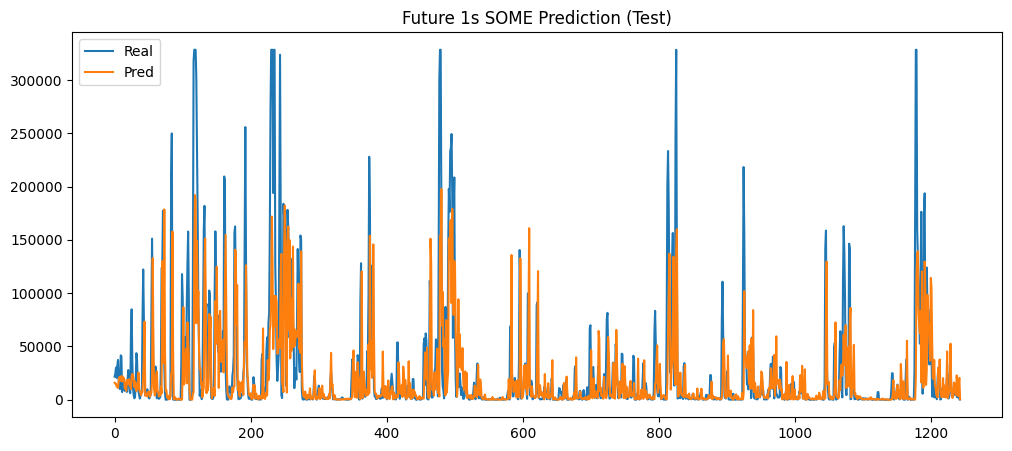

In [29]:
# 画图（测试集）
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(np.expm1(y_test.values), label="Real")
plt.plot(np.expm1(pred_test), label="Pred")
plt.legend()
plt.title("Future 1s SOME Prediction (Test)")
plt.show()

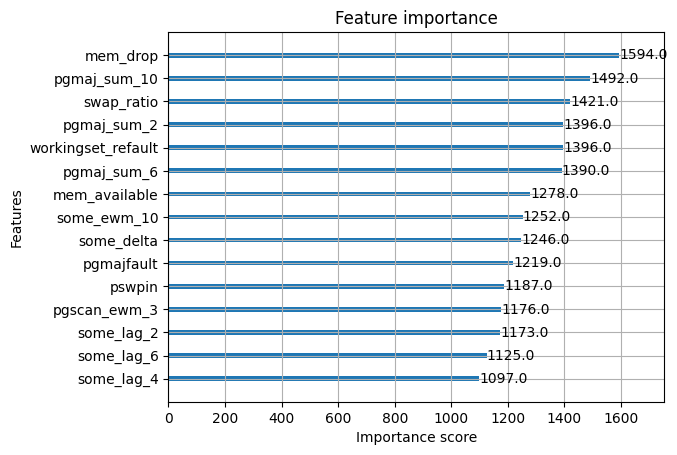

In [31]:
# 特征重要性
xgb.plot_importance(model, max_num_features=15)
plt.show()

In [32]:
# =============================================
# Optuna 自动调参（基于验证集 Log MSE）
# =============================================
import optuna
from sklearn.metrics import mean_squared_error as mse

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'n_estimators': 3000,
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'objective': 'reg:tweedie',
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.1, 1.9),
        'random_state': 42,
        'early_stopping_rounds': 120,
    }
    m = xgb.XGBRegressor(**params)
    m.fit(
        X_train, y_train,
        sample_weight=weights,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )
    pred_v = m.predict(X_valid)
    return mse(y_valid, pred_v)

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=60, show_progress_bar=True)

print(f"\nBest Log MSE (valid): {study.best_value:.4f}")
print(f"Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

Best trial: 48. Best value: 3.02518: 100%|██████████| 60/60 [06:08<00:00,  6.13s/it]


Best Log MSE (valid): 3.0252
Best params:
  max_depth: 7
  learning_rate: 0.01237725755530744
  subsample: 0.7042598426997672
  colsample_bytree: 0.5817363713295735
  reg_alpha: 0.006928683843597892
  reg_lambda: 2.461096860911011
  min_child_weight: 8
  gamma: 0.12010728872785961
  tweedie_variance_power: 1.2226298634521118


In [33]:
# 用 Optuna 最优参数重新训练最终模型
best_p = study.best_params.copy()
best_p.update({
    'n_estimators': 3000,
    'objective': 'reg:tweedie',
    'random_state': 42,
    'early_stopping_rounds': 120,
})

model_tuned = xgb.XGBRegressor(**best_p)
model_tuned.fit(
    X_train, y_train,
    sample_weight=weights,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100
)

# 在测试集评估
from sklearn.metrics import r2_score, mean_absolute_error

pred_tuned = model_tuned.predict(X_test)
pred_tuned_real = np.expm1(pred_tuned)
y_real_t = np.expm1(y_test)

print("\n=== 调参后测试集 ===")
print(f"  Log R2:   {r2_score(y_test, pred_tuned):.4f}")
print(f"  Log MSE:  {mse(y_test, pred_tuned):.4f}")
print(f"  Log MAE:  {mean_absolute_error(y_test, pred_tuned):.4f}")
print(f"  Real R2:  {r2_score(y_real_t, pred_tuned_real):.4f}")
print(f"  Real MSE: {mse(y_real_t, pred_tuned_real):.2f}")
print(f"  Real MAE: {mean_absolute_error(y_real_t, pred_tuned_real):.2f}")

[0]	validation_0-tweedie-nloglik@1.22263:29.23290	validation_1-tweedie-nloglik@1.22263:29.31867
[100]	validation_0-tweedie-nloglik@1.22263:28.99801	validation_1-tweedie-nloglik@1.22263:29.10884
[200]	validation_0-tweedie-nloglik@1.22263:28.94433	validation_1-tweedie-nloglik@1.22263:29.07018
[300]	validation_0-tweedie-nloglik@1.22263:28.92238	validation_1-tweedie-nloglik@1.22263:29.05999
[400]	validation_0-tweedie-nloglik@1.22263:28.90790	validation_1-tweedie-nloglik@1.22263:29.05481
[500]	validation_0-tweedie-nloglik@1.22263:28.89708	validation_1-tweedie-nloglik@1.22263:29.05195
[600]	validation_0-tweedie-nloglik@1.22263:28.88848	validation_1-tweedie-nloglik@1.22263:29.05024
[700]	validation_0-tweedie-nloglik@1.22263:28.88113	validation_1-tweedie-nloglik@1.22263:29.04926
[800]	validation_0-tweedie-nloglik@1.22263:28.87530	validation_1-tweedie-nloglik@1.22263:29.04851
[900]	validation_0-tweedie-nloglik@1.22263:28.86987	validation_1-tweedie-nloglik@1.22263:29.04791
[1000]	validation_0-tw

In [34]:
# =============================================
# 两阶段模型：Stage-1 Spike 分类器 + Stage-2 回归器
# =============================================
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# --- Stage 1: Spike 二分类器 ---
# 分类标签：future_1s_some > p75 即为 spike
spike_thr = train['future_1s_some'].quantile(0.75)
print(f"Spike 分类阈值 (train p75): {spike_thr:.0f}")

y_train_cls = (train['future_1s_some'] > spike_thr).astype(int)
y_valid_cls = (valid['future_1s_some'] > spike_thr).astype(int)
y_test_cls  = (test['future_1s_some']  > spike_thr).astype(int)

# 计算类别权重平衡正负样本
neg_count = (y_train_cls == 0).sum()
pos_count = (y_train_cls == 1).sum()
scale_pos = neg_count / max(pos_count, 1)
print(f"\u6b63样本: {pos_count}, \u8d1f样本: {neg_count}, scale_pos_weight: {scale_pos:.2f}")

clf = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth=5,
    learning_rate=0.02,
    subsample=0.85,
    colsample_bytree=0.75,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=3,
    gamma=0.1,
    scale_pos_weight=scale_pos,
    eval_metric='logloss',
    random_state=42,
    early_stopping_rounds=100
)

clf.fit(
    X_train, y_train_cls,
    eval_set=[(X_valid, y_valid_cls)],
    verbose=100
)

# 评估分类器
for ds_name, X_ds, y_ds in [('Valid', X_valid, y_valid_cls), ('Test', X_test, y_test_cls)]:
    prob = clf.predict_proba(X_ds)[:, 1]
    pred_c = (prob >= 0.5).astype(int)
    print(f"\n{ds_name} Spike 分类:")
    print(f"  Accuracy:  {accuracy_score(y_ds, pred_c):.4f}")
    print(f"  Precision: {precision_score(y_ds, pred_c, zero_division=0):.4f}")
    print(f"  Recall:    {recall_score(y_ds, pred_c, zero_division=0):.4f}")
    print(f"  F1:        {f1_score(y_ds, pred_c, zero_division=0):.4f}")

Spike 分类阈值 (train p75): 23034
正样本: 2092, 负样本: 6275, scale_pos_weight: 3.00
[0]	validation_0-logloss:0.68701
[100]	validation_0-logloss:0.47802
[200]	validation_0-logloss:0.45718
[300]	validation_0-logloss:0.45002
[400]	validation_0-logloss:0.44408
[500]	validation_0-logloss:0.43916
[600]	validation_0-logloss:0.43276
[700]	validation_0-logloss:0.42964
[800]	validation_0-logloss:0.42557
[900]	validation_0-logloss:0.42175
[1000]	validation_0-logloss:0.41853
[1100]	validation_0-logloss:0.41627
[1200]	validation_0-logloss:0.41523
[1300]	validation_0-logloss:0.41267
[1400]	validation_0-logloss:0.41162
[1500]	validation_0-logloss:0.41069
[1600]	validation_0-logloss:0.40976
[1700]	validation_0-logloss:0.40925
[1800]	validation_0-logloss:0.40852
[1900]	validation_0-logloss:0.40906
[1918]	validation_0-logloss:0.40898

Valid Spike 分类:
  Accuracy:  0.8257
  Precision: 0.6551
  Recall:    0.6677
  F1:        0.6613

Test Spike 分类:
  Accuracy:  0.8222
  Precision: 0.6831
  Recall:    0.5969
  F1:   

In [35]:
# --- Stage 2: 对 spike 样本单独训练回归器 ---
spike_mask_train = y_train_cls == 1
spike_mask_valid = y_valid_cls == 1

X_train_spike = X_train[spike_mask_train]
y_train_spike = y_train[spike_mask_train]

X_valid_spike = X_valid[spike_mask_valid]
y_valid_spike = y_valid[spike_mask_valid]

print(f"Spike 训练样本: {len(X_train_spike)}, Spike 验证样本: {len(X_valid_spike)}")

reg_spike = xgb.XGBRegressor(
    n_estimators=2000,
    max_depth=5,
    learning_rate=0.02,
    subsample=0.85,
    colsample_bytree=0.75,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=3,
    gamma=0.1,
    objective='reg:tweedie',
    tweedie_variance_power=1.35,
    random_state=42,
    early_stopping_rounds=80
)

reg_spike.fit(
    X_train_spike, y_train_spike,
    eval_set=[(X_valid_spike, y_valid_spike)],
    verbose=100
)

print(f"Spike 回归器训练完成，最佳轮次: {reg_spike.best_iteration}")

Spike 训练样本: 2092, Spike 验证样本: 310
[0]	validation_0-tweedie-nloglik@1.35:21.23251
[100]	validation_0-tweedie-nloglik@1.35:21.22939
[200]	validation_0-tweedie-nloglik@1.35:21.22924
[300]	validation_0-tweedie-nloglik@1.35:21.22923
[400]	validation_0-tweedie-nloglik@1.35:21.22922
[500]	validation_0-tweedie-nloglik@1.35:21.22921
[554]	validation_0-tweedie-nloglik@1.35:21.22921
Spike 回归器训练完成，最佳轮次: 474


In [36]:
# --- 两阶段融合预测 + 最优阈值搜索 ---
import matplotlib.pyplot as plt

# 在验证集上搜索最优分类阈值（最大化 F1）
prob_valid = clf.predict_proba(X_valid)[:, 1]
pred_base_valid = model_tuned.predict(X_valid)
pred_spike_valid = reg_spike.predict(X_valid)

best_f1, best_thr_clf = 0, 0.5
for t in np.arange(0.20, 0.80, 0.02):
    is_spike = (prob_valid >= t).astype(int)
    y_binary = y_valid_cls.values
    f1 = f1_score(y_binary, is_spike, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thr_clf = t

print(f"最优分类阈值 (valid F1={best_f1:.4f}): {best_thr_clf:.2f}")

# 融合预测：若分类器判为 spike，用 spike 回归器；否则用调参后基线模型
def two_stage_predict(X_ds, clf, reg_spike, model_base, thr):
    prob = clf.predict_proba(X_ds)[:, 1]
    is_spike = prob >= thr
    pred = model_base.predict(X_ds).copy()
    if is_spike.any():
        pred[is_spike] = reg_spike.predict(X_ds[is_spike])
    return pred, prob

# 测试集融合预测
pred_2s, prob_test = two_stage_predict(X_test, clf, reg_spike, model_tuned, best_thr_clf)
pred_2s_real = np.expm1(pred_2s)
y_real_t = np.expm1(y_test)

print("\n=== 两阶段模型测试集 ===")
print(f"  Log R2:   {r2_score(y_test, pred_2s):.4f}")
print(f"  Log MSE:  {mse(y_test, pred_2s):.4f}")
print(f"  Log MAE:  {mean_absolute_error(y_test, pred_2s):.4f}")
print(f"  Real R2:  {r2_score(y_real_t, pred_2s_real):.4f}")
print(f"  Real MSE: {mse(y_real_t, pred_2s_real):.2f}")
print(f"  Real MAE: {mean_absolute_error(y_real_t, pred_2s_real):.2f}")

# Spike 检测指标
print("\n=== 两阶段 Spike 检测 ===")
for q, label in [(0.75, '75th'), (0.90, '90th'), (0.95, '95th')]:
    thr = y_real_t.quantile(q)
    y_cls = (y_real_t > thr).astype(int)
    pred_cls = (pred_2s_real > thr).astype(int)
    print(f"\n  阈值={thr:.0f} ({label}):")
    print(f"    Precision: {precision_score(y_cls, pred_cls, zero_division=0):.4f}")
    print(f"    Recall:    {recall_score(y_cls, pred_cls, zero_division=0):.4f}")
    print(f"    F1:        {f1_score(y_cls, pred_cls, zero_division=0):.4f}")

最优分类阈值 (valid F1=0.6613): 0.50

=== 两阶段模型测试集 ===
  Log R2:   0.3930
  Log MSE:  3.1987
  Log MAE:  1.3576
  Real R2:  0.4160
  Real MSE: 1898795743.42
  Real MAE: 21632.99

=== 两阶段 Spike 检测 ===

  阈值=24816 (75th):
    Precision: 0.6414
    Recall:    0.6270
    F1:        0.6341

  阈值=89880 (90th):
    Precision: 0.6588
    Recall:    0.4480
    F1:        0.5333

  阈值=157804 (95th):
    Precision: 0.8462
    Recall:    0.1746
    F1:        0.2895


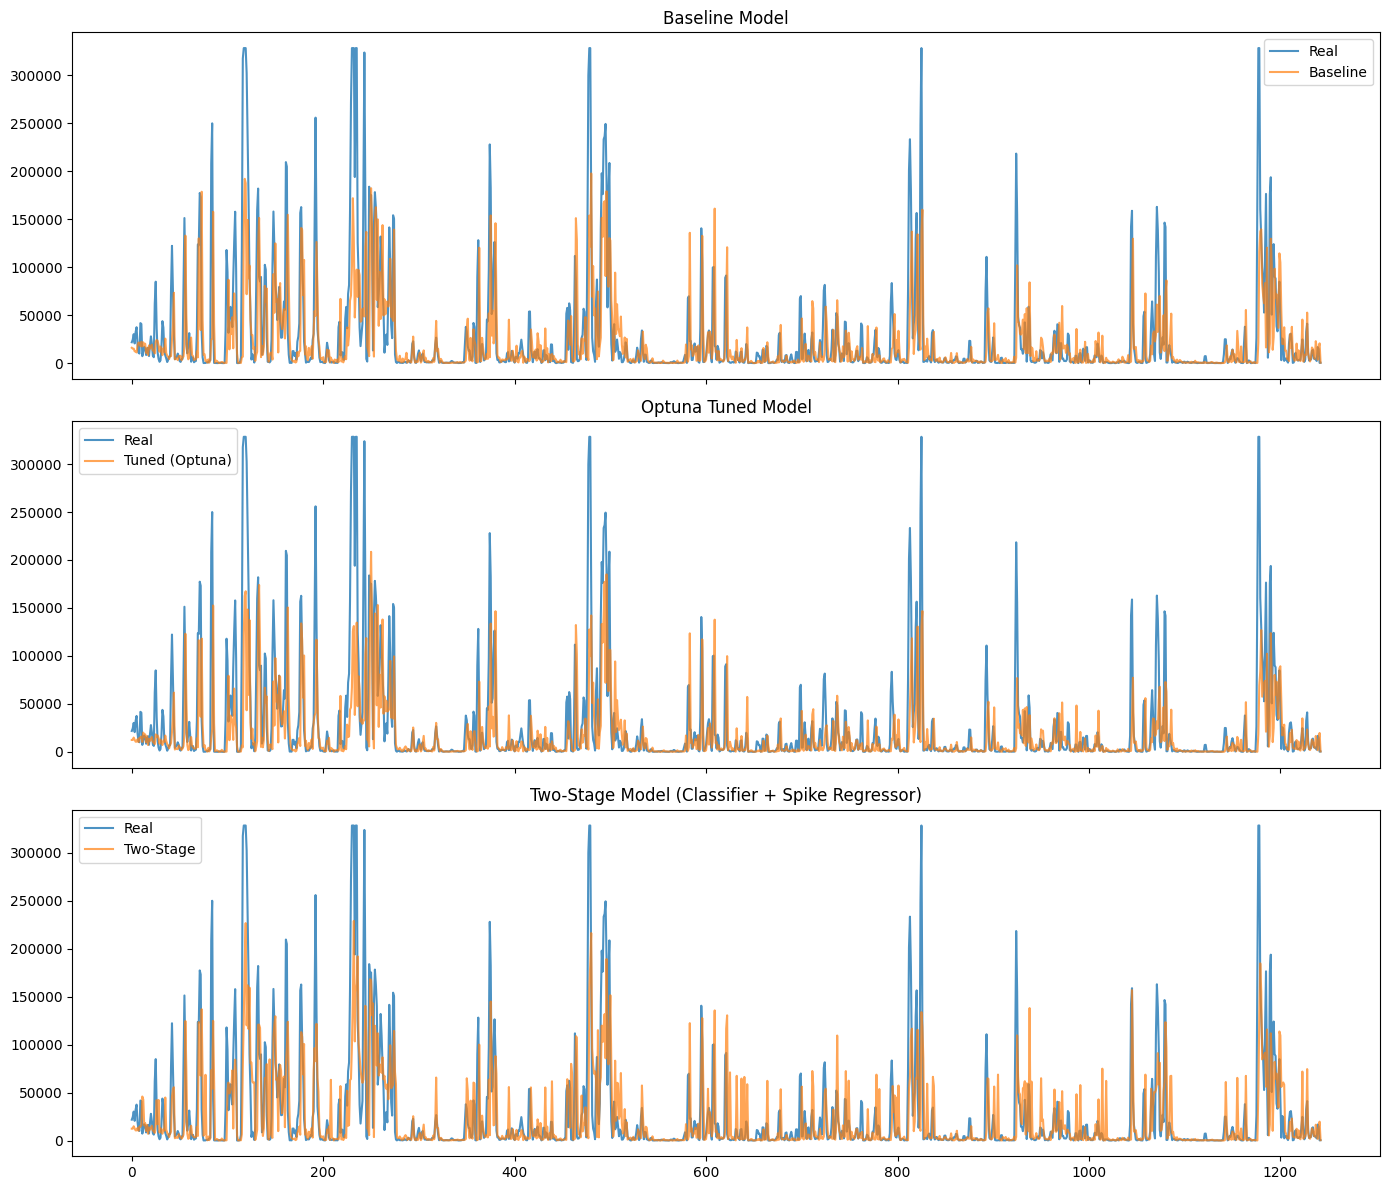

In [37]:
# 对比图：原始 vs 调参 vs 两阶段
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

axes[0].plot(y_real_t.values, label='Real', alpha=0.8)
axes[0].plot(np.expm1(model.predict(X_test)), label='Baseline', alpha=0.7)
axes[0].set_title('Baseline Model')
axes[0].legend()

axes[1].plot(y_real_t.values, label='Real', alpha=0.8)
axes[1].plot(pred_tuned_real, label='Tuned (Optuna)', alpha=0.7)
axes[1].set_title('Optuna Tuned Model')
axes[1].legend()

axes[2].plot(y_real_t.values, label='Real', alpha=0.8)
axes[2].plot(pred_2s_real, label='Two-Stage', alpha=0.7)
axes[2].set_title('Two-Stage Model (Classifier + Spike Regressor)')
axes[2].legend()

plt.tight_layout()
plt.show()